In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# IMPORTING THE IMAGE DATA FROM THE RESPECTIVE DIRECTORY

In [4]:
data_dir = "/content/drive/MyDrive/traindata"
image_size=(180,180)
img_height=180
img_width=180
batch_size = 32

# TRAINING AND VALIDATION SPLIT

In [5]:
train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=image_size,
    batch_size=batch_size
)

Found 361 files belonging to 4 classes.
Using 289 files for training.


In [6]:
val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=image_size,
    batch_size=batch_size
)

Found 361 files belonging to 4 classes.
Using 72 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['Chickenpox', 'Measles', 'Monkeypox', 'Normal']


# VISUALISING THE DATA

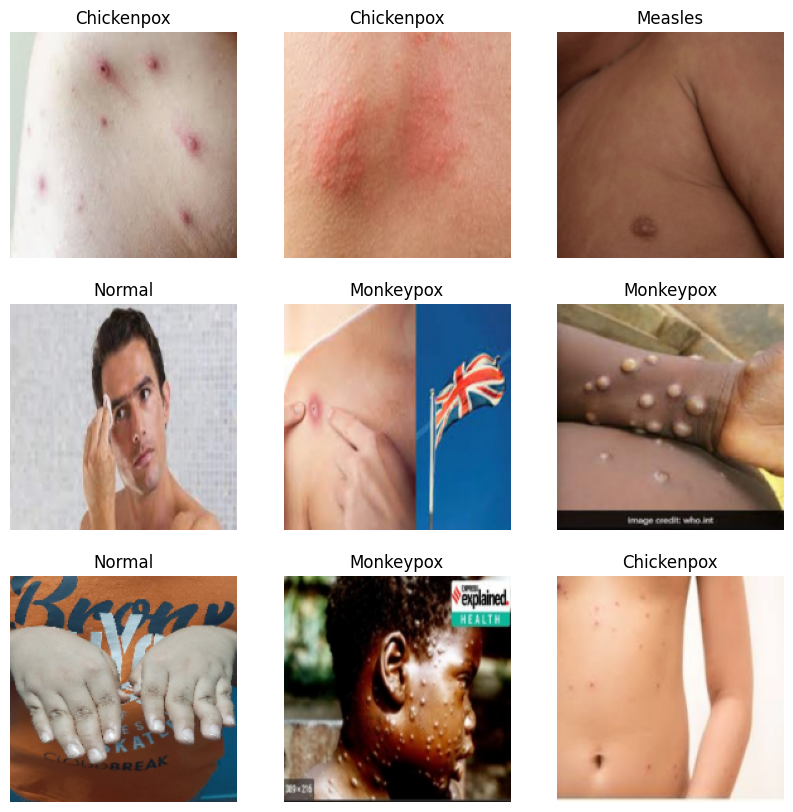

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [9]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


# DATASET CONFIGURATION FOR PERFORMANCE

In [10]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# DATA STANDARDISATION

In [11]:
normalization_layer = layers.Rescaling(1./255)

In [12]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


# BUILDING THE SEQUENTIAL MODEL

In [13]:
num_classes = len(class_names)

model = Sequential([
layers.Rescaling(1./255, input_shape=(img_height,img_width,3)),
layers.Conv2D(16,3, padding="same", activation="relu"),
layers.MaxPooling2D(pool_size=(2, 2)),
layers.Conv2D(32,3, padding="same", activation="relu"),
layers.MaxPooling2D(pool_size=(2, 2)),
layers.Conv2D(64, 3, padding='same', activation='relu'),
layers.MaxPooling2D(),
layers.Dropout(0.2),
layers.Flatten(),
layers.Dense(128, activation='relu'),
layers.Dense(num_classes)])

# COMPILING AND SUMMARISING THE MODEL
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
print(model.summary())

# FITTING THE MODEL
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

# SAVING THE MODEL

In [15]:
model.save("/content/sample_data/skinmodelv1.h5")

# VISUALISING THE TRAINING RESULTS

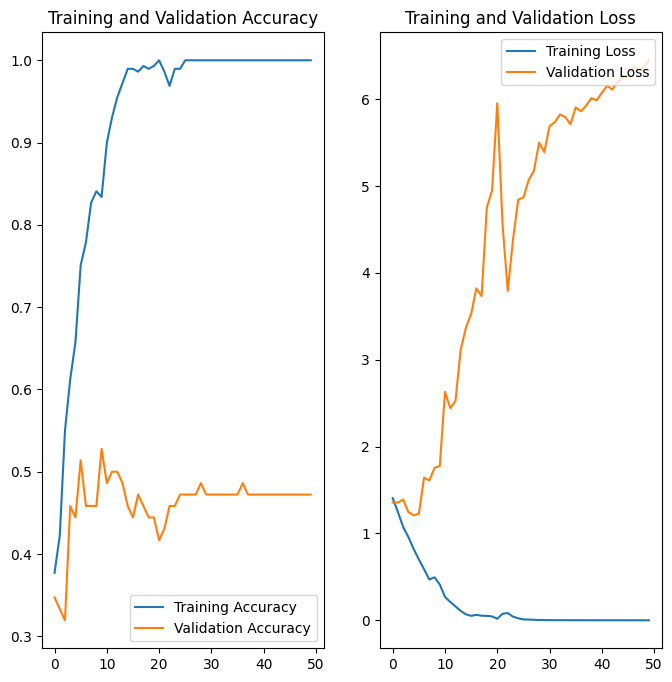

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

###Prediction

In [23]:
skin_data_folder = '/content/drive/MyDrive/skindata-test'
skin_data_filenames = ["cp.jpeg","measles21.png","ml.jpeg","monkeypx.webp","normal22.png"]

model = tf.keras.models.load_model("/content/sample_data/skinmodelv1.h5")
for filename in skin_data_filenames:
    image_path = os.path.join(skin_data_folder, filename)

    img = tf.keras.utils.load_img(image_path, target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    class_names = ['Chickenpox', 'Measles', 'Monkeypox', 'Normal']

    print("Image: ", filename)
    print("Predicted class: ", class_names[np.argmax(score)])
    print("Confidence: {:.2f}%".format(100 * np.max(score)))
    print()

1/1 [==============================] - 0s 64ms/step
Image:  cp.jpeg
Predicted class:  Chickenpox
Confidence: 99.75%

1/1 [==============================] - 0s 24ms/step
Image:  measles21.png
Predicted class:  Measles
Confidence: 94.85%

1/1 [==============================] - 0s 23ms/step
Image:  ml.jpeg
Predicted class:  Measles
Confidence: 99.99%

1/1 [==============================] - 0s 29ms/step
Image:  monkeypx.webp
Predicted class:  Monkeypox
Confidence: 100.00%

1/1 [==============================] - 0s 22ms/step
Image:  normal22.png
Predicted class:  Normal
Confidence: 100.00%



##Prediction with image

1/1 [==============================] - 0s 96ms/step


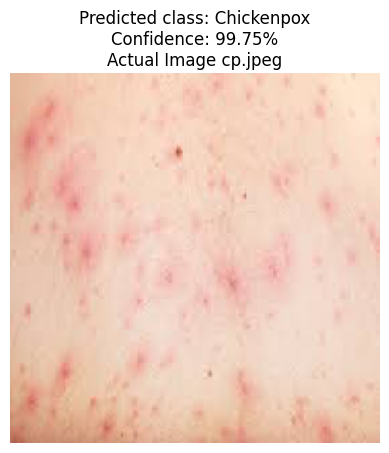

1/1 [==============================] - 0s 23ms/step


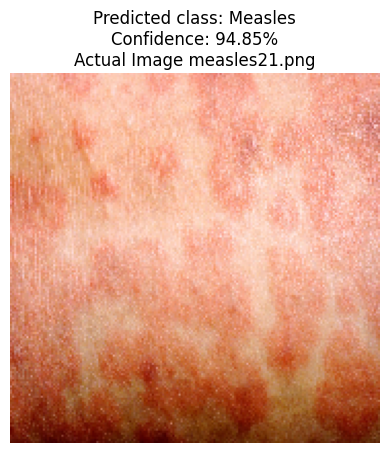

1/1 [==============================] - 0s 34ms/step


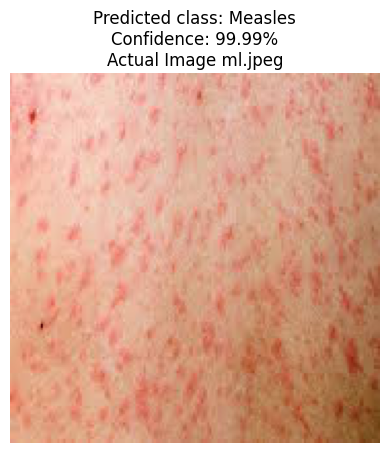

1/1 [==============================] - 0s 22ms/step


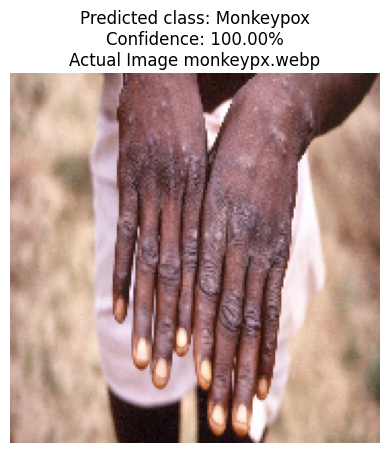

1/1 [==============================] - 0s 30ms/step


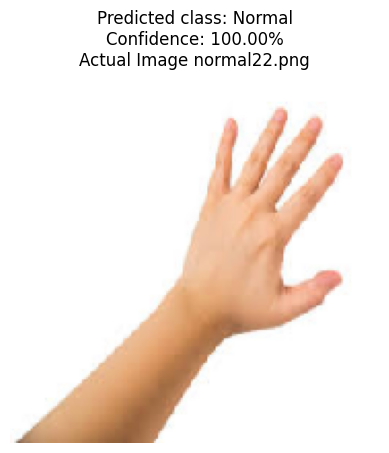

In [21]:
skin_data_folder = '/content/drive/MyDrive/skindata-test'
skin_data_filenames = ["cp.jpeg", "measles21.png", "ml.jpeg", "monkeypx.webp", "normal22.png"]

img_height, img_width = 180, 180

model = tf.keras.models.load_model("/content/sample_data/skinmodelv1.h5")
class_names = ['Chickenpox', 'Measles', 'Monkeypox', 'Normal']

for filename in skin_data_filenames:
    image_path = os.path.join(skin_data_folder, filename)

    img = tf.keras.utils.load_img(image_path, target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    predicted_class = class_names[np.argmax(score)]
    confidence = 100 * np.max(score)

    # Display the image and prediction results
    plt.imshow(img)
    plt.title(f"Predicted class: {predicted_class}\nConfidence: {confidence:.2f}%\nActual Image {filename}")
    plt.axis('off')
    plt.show()
